In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yt
import trident
import chollaread
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.colors as colors
import colorcet as cc
from matplotlib.cm import get_cmap
from astropy.constants import M_sun
import matplotlib.axes

/Users/sofimar/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:768: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [2]:
ds = chollaread.load('/Users/sofimar/Desktop/Summer Research/140.h5.0',cell_size_cgs=(10/256)*chollaread.kpc)

yt : [INFO     ] 2022-06-27 12:20:02,357 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-06-27 12:20:02,357 Parameters: domain_dimensions         = [512 256 256]
yt : [INFO     ] 2022-06-27 12:20:02,358 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-06-27 12:20:02,358 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22]
yt : [INFO     ] 2022-06-27 12:20:02,358 Parameters: cosmological_simulation   = 0.0


In [3]:
def make_ray(x0, y0, z0, x, y, z, num):
    
    k = (3.086E+21)*10 # Code length
    
    ray_start = np.array([x0,y0,z0])*k
    ray_end = np.array([x,y,z])*k
    
    ray = trident.make_simple_ray(ds,
                                 start_position=ray_start,
                                 end_position=ray_end,
                                 data_filename= 'ray_'+str(num)+'.h5',
                                 lines='all',
                                 ftype='gas')
    return ray

In [4]:
def spec(ray_, lmin, lmax, dlam=0.001, line=None, 
             el=None, rom_num=None, lrest=None, gamma=None, f_value=None, DIY=False):
    
    # Make array of rays
    k = (3.086E+21)*10 # Code length
    cu = 1/256
    
    arrays = []
    
    for i in range(len(ray_)):
        ray = ray_[i]

        sg = trident.SpectrumGenerator(lambda_min= lmin, lambda_max= lmax, dlambda=dlam)

        if DIY==True:

            DIY_line = el+' '+str(rom_num)+' '+str(int(lrest))
            sg.add_line_to_database(el, rom_num, lrest, gamma,f_value, field=None,
                                    identifier=DIY_line)

            sg.make_spectrum(ray, lines=[DIY_line])
            sg.save_spectrum('spec.txt')

        else:
            sg.make_spectrum(ray, lines=[line])
            sg.save_spectrum('spec.txt')
            
        f = np.loadtxt('spec.txt')
        lam = f[:,0] # All rows, 1st column
        flux = f[:,2]

        tog = np.array([lam, flux])
        arrays.append(tog)
        

        
  
    
    # Average Flux
#     flux_list = []

    
#     flux_ = arrays[1]
#     flux_list.append(flux_) # Append flux to a list
#     flux_arr = np.array(flux_list) # Turn list into an array
#     flux_a = flux_arr.T # Transpose array
        

        
#     reds = get_cmap('cet_CET_L18')
#     colors = reds(np.linspace(0.25,1,6))
    color_= ['deeppink', 'orangered', 'teal', 'mediumblue', 'black', 'olivedrab', 'crimson']
    fig = plt.figure(figsize=(15, 5))
    
    for j in range(len(ray_)):
        plt.plot(arrays[0][0], arrays[j][1], color=color_[j], label='Ray '+str(j+1), alpha=0.85-(int(j)/10))
    plt.xlim(lmin, lmax)
    if DIY==False:
        plt.title(line+" '140.h5.0' (d$\lambda$ = " + str(dlam)+")", fontsize=14)
    else:
        plt.title(el+" "+rom_num+" "+str(int(lrest))+" '140.h5.0' (d$\lambda$ = " + str(dlam)+")", fontsize=14)
    plt.xlabel('Wavelength [$\AA$]', fontsize=12)
    plt.ylabel('Relative Flux', fontsize=12)
    plt.legend(fontsize=12)

    return arrays

In [5]:
def slice_plot(xx,yy,zz,x,y,z,rx,ry,rz,dx_,dy_,dz_, num, y_arr=False, xmar=False):
    x_bin = 10**np.linspace(np.log10(np.max(xx))-5,np.log10(np.max(xx)),30)
    y_bin = 10**np.linspace(np.log10(np.max(yy))-5,np.log10(np.max(yy)),30)
    
    get_cmap("cet_CET_R3")
    get_cmap("cet_CET_D1A")
    
    p = np.array(ds.all_data()[('gas', 'temperature')])
    a = p.reshape(512, 256, 256)
    ax_x = np.arange(513)*(20/512)-10
    ax_y = np.arange(257)*(20/512)-5
    ax_z = np.arange(257)*(20/512)-5
    
   
    fig = plt.figure(figsize=(16,12))
    fig.suptitle('Ray '+ num, fontsize=17)
    
    p1 = fig.add_subplot(2,2,1)
    p1.set_facecolor('black')
    plt.pcolormesh(ax_y, ax_z, a[x,:,:].T, cmap = "cet_CET_D1A", norm=colors.LogNorm())
    plt.xlabel('y (kpc)', fontsize = 15)
    plt.ylabel('z (kpc)', fontsize = 15)
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    cb = plt.colorbar(pad=0.01) 
    cb.set_label(label='Temperature [K]', size=15)
    cb.ax.tick_params(labelsize='large')
    plt.clim(vmin=3*10**3, vmax=3*10**6)
    if xmar==True:
        plt.plot(ry,rz,marker='*', color='gainsboro',  markersize=10)
    else:
        plt.arrow(ry,rz,dy_,dz_,length_includes_head=True,color='gainsboro',head_width=0.14, lw=1.15)
    
    p2 = fig.add_subplot(2,2,2)
    p2.set_facecolor('black')
    plt.pcolormesh(ax_x, ax_z, a[:,y,:].T, cmap = "cet_CET_D1A", norm=colors.LogNorm())
    plt.xlabel('x (kpc)', fontsize = 15)
    plt.ylabel('z (kpc)', fontsize = 15)
    plt.xlim(-10,10)
    plt.ylim(-5,5)
    cb2 = plt.colorbar(pad=0.01) 
    cb2.set_label(label='Temperature [K]', size=15)
    cb2.ax.tick_params(labelsize='large')
    plt.clim(vmin=3*10**3, vmax=3*10**6)
    if y_arr==True:
        plt.arrow(rx,rz,dx_,dz_,length_includes_head=True,color='gainsboro',head_width=0.14, lw=1.15)
    else:
        plt.plot(rx,rz,marker='*', color='gainsboro',  markersize=10)
        
    
    p3 = fig.add_subplot(2,2,3)
    p1.set_facecolor('black')
    plt.pcolormesh(ax_x, ax_y, a[:,:,z].T, cmap = "cet_CET_D1A", norm=colors.LogNorm())
    plt.xlabel('x (kpc)', fontsize = 15)
    plt.ylabel('y (kpc)', fontsize = 15)
    plt.xlim(-10,10)
    plt.ylim(-5,5)
    cb3 = plt.colorbar(pad=0.01) 
    cb3.set_label(label='Temperature [K]', size=15)
    cb3.ax.tick_params(labelsize='large')
    plt.clim(vmin=3*10**3, vmax=3*10**6)
    plt.arrow(rx,ry,dx_,dy_,length_includes_head=True,color='gainsboro',head_width=0.14, lw=1.15)

    
    p4 = fig.add_subplot(2,2,4)
    p4.set_facecolor('black')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(10**-30, 10**-25)
    plt.xlabel('Density $(g /cm^3)$', fontsize=14)
    plt.ylabel('Temperature [K]', fontsize=14)
#     plt.title('All Gas (Unweighted)', fontsize=18)
    plt.xticks(fontsize='large')
    plt.yticks(fontsize='large')

    hist4,xedges,yedges = np.histogram2d(xx,yy,bins=[x_bin,y_bin],normed=False, weights=zz)
    plt.pcolormesh(xedges[:-1],yedges[:-1],hist4.transpose(), norm=colors.LogNorm(), cmap="cet_CET_R3")

    cb4 = plt.colorbar(pad=0.01)
    cb4.set_label(label='Cell Mass [M$_\odot$]', size=14)
    cb4.ax.tick_params(labelsize='large')
    cb4.ax.tick_params(labelsize='large')
    plt.clim(vmin=5*10**1, vmax=10**6)



    plt.tight_layout(pad=1)

In [8]:
ray1 = make_ray(0.94,0,0.5,0.94,1,0.5, 1)
ray2 = make_ray(1.0528,0,0.518, 1.0528, 1, 0.518, 3) # Ray 3 in other notebook
ray3 = make_ray(1.0833,0,0.478, 1.0833, 1, 0.478, 4) # Ray 4 in other notebook

yt : [INFO     ] 2022-06-27 12:25:25,929 Getting segment at z = 0.0: [0.47 0.   0.25] unitary to [0.47 0.5  0.25] unitary.
yt : [INFO     ] 2022-06-27 12:25:25,931 Getting subsegment: [0.47 unitary, 0.0 unitary, 0.25 unitary] to [0.47 unitary, 0.5 unitary, 0.25 unitary].
yt : [INFO     ] 2022-06-27 12:25:26,584 Saving field data to yt dataset: ray_1.h5.
yt : [INFO     ] 2022-06-27 12:25:26,671 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2022-06-27 12:25:26,671 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2022-06-27 12:25:26,672 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2022-06-27 12:25:26,672 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2022-06-27 12:25:26,672 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2022-06-27 12:25:26,683 Getting segment at z = 0.0: [0.5264 0.     0.259 ] unitary to [0.5264 0.5    0.259 ] unitary.
yt : [INFO 

In [9]:
rays = [ray1,ray2,ray3]

In [10]:
M= 1.9884099E30 

den = np.array(ray1.all_data()[('gas','density')])
temp = np.array(ray1.all_data()[('gas','temperature')])
cell_mass = np.array(ray1.all_data()[('gas','cell_mass')])/M

den2 = np.array(ray2.all_data()[('gas','density')])
temp2 = np.array(ray2.all_data()[('gas','temperature')])
cell_mass2 = np.array(ray2.all_data()[('gas','cell_mass')])/M

den3 = np.array(ray3.all_data()[('gas','density')])
temp3 = np.array(ray3.all_data()[('gas','temperature')])
cell_mass3 = np.array(ray3.all_data()[('gas','cell_mass')])/M

yt : [INFO     ] 2022-06-27 12:25:28,883 Allocating for 2.560e+02 particles (index particle type 'all')
yt : [INFO     ] 2022-06-27 12:25:28,891 Identified 1.210e+02 octs
yt : [INFO     ] 2022-06-27 12:25:29,039 Allocating for 2.560e+02 particles (index particle type 'all')
yt : [INFO     ] 2022-06-27 12:25:29,044 Identified 1.210e+02 octs
yt : [INFO     ] 2022-06-27 12:25:29,191 Allocating for 2.560e+02 particles (index particle type 'all')
yt : [INFO     ] 2022-06-27 12:25:29,196 Identified 1.210e+02 octs


<ipython-input-5-19a8e93af9b4>:77: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xedges[:-1],yedges[:-1],hist4.transpose(), norm=colors.LogNorm(), cmap="cet_CET_R3")


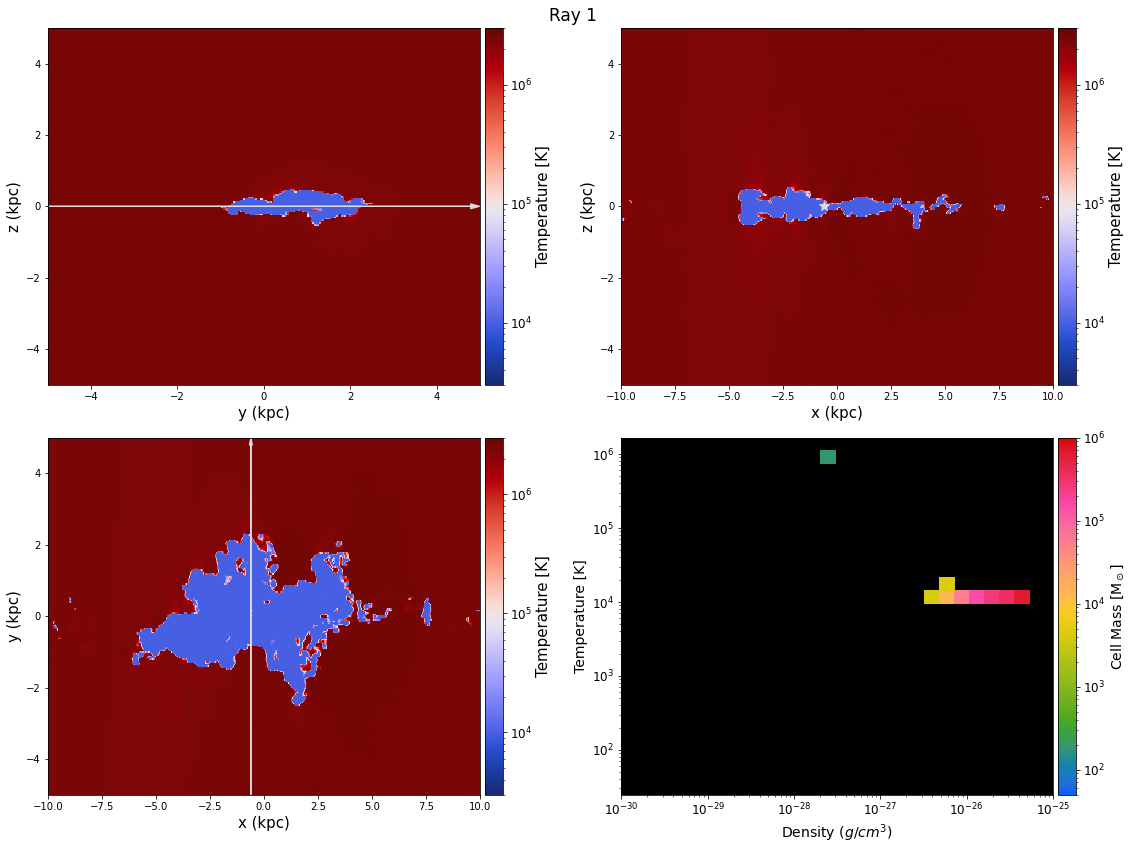

In [12]:
slice_plot(xx=den,yy=temp,zz=cell_mass,x=240,y=128,z=128,
     rx=-0.6,ry=-5,rz=0,dx_=0,dy_=10,dz_=0, num='1', y_arr=False)

<ipython-input-5-19a8e93af9b4>:77: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xedges[:-1],yedges[:-1],hist4.transpose(), norm=colors.LogNorm(), cmap="cet_CET_R3")


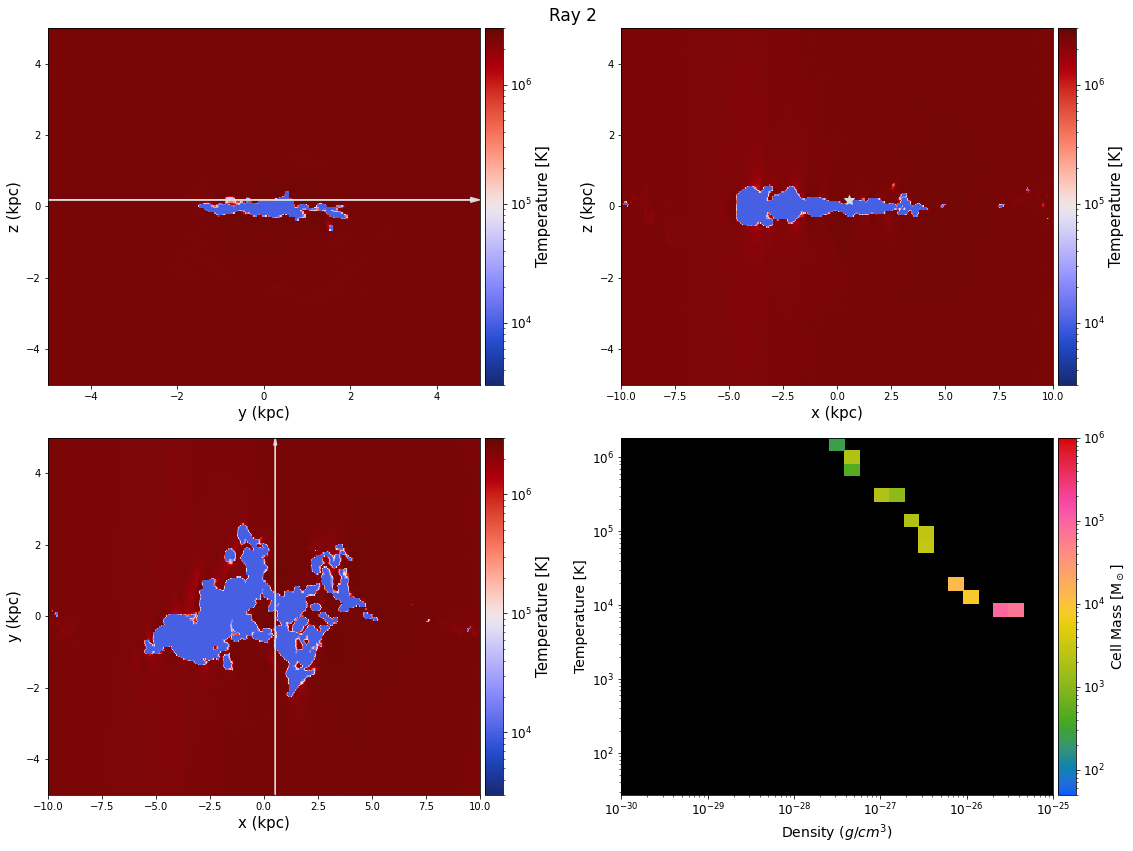

In [14]:
slice_plot(xx=den2,yy=temp2,zz=cell_mass2,x=269,y=123,z=132,
     rx=0.528,ry=-5,rz=0.18,dx_=0,dy_=10,dz_=0, num='2')

<ipython-input-5-19a8e93af9b4>:77: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xedges[:-1],yedges[:-1],hist4.transpose(), norm=colors.LogNorm(), cmap="cet_CET_R3")


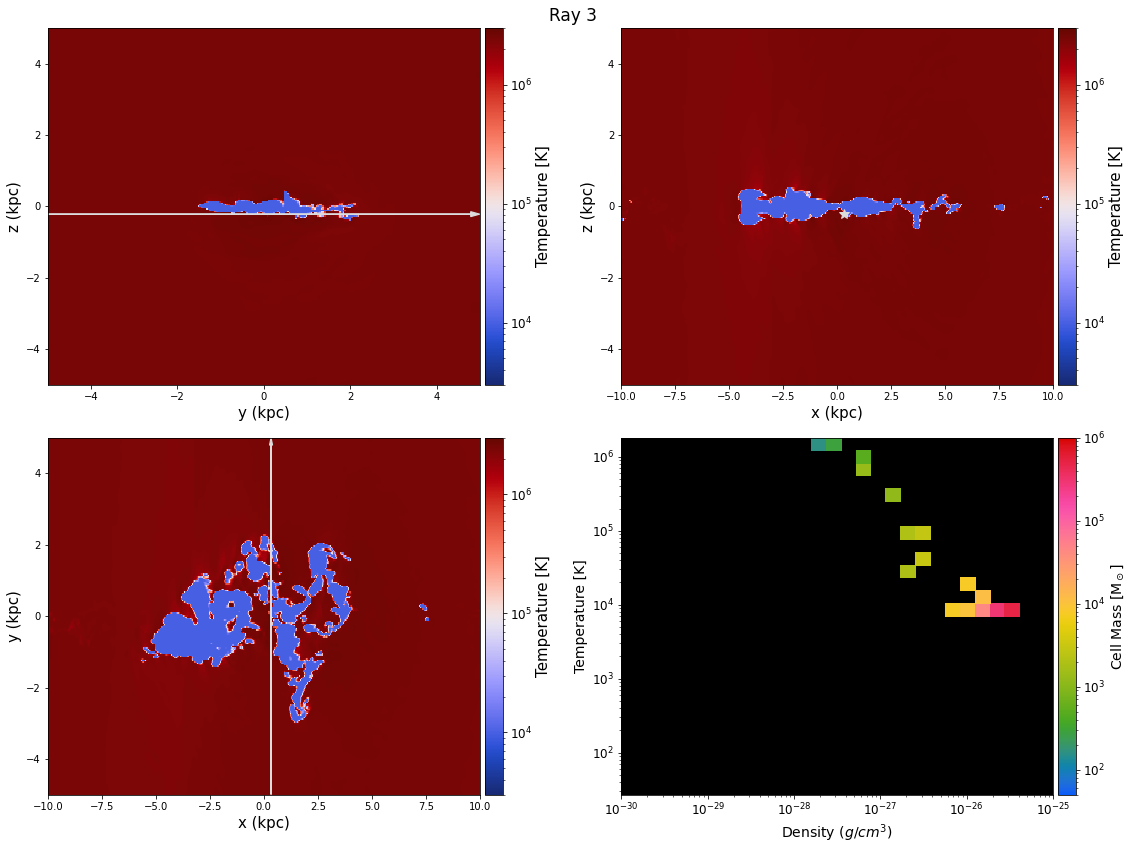

In [16]:
slice_plot(xx=den3,yy=temp3,zz=cell_mass3,x=264,y=128,z=122,
     rx=0.333,ry=-5,rz=-0.22,dx_=0,dy_=10,dz_=0, num='3')

# Ly a

yt : [INFO     ] 2022-06-27 02:36:02,274 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:02,286 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 256/256 [00:01<00:00, 142.93it/s] 
yt : [INFO     ] 2022-06-27 02:36:04,121 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2022-06-27 02:36:04,122 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:04,289 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:04,292 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 256/256 [00:00<00:00, 571.22it/s] 
yt : [INFO     ] 2022-06-27 02:36:04,768 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2022-06-27 02:36:04,769 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:04,938 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:04,941 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|

[array([[1.209000e+03, 1.209001e+03, 1.209002e+03, ..., 1.224998e+03,
         1.224999e+03, 1.225000e+03],
        [9.909983e-01, 9.909956e-01, 9.909929e-01, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.209000e+03, 1.209001e+03, 1.209002e+03, ..., 1.224998e+03,
         1.224999e+03, 1.225000e+03],
        [9.964224e-01, 9.964213e-01, 9.964202e-01, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.209000e+03, 1.209001e+03, 1.209002e+03, ..., 1.224998e+03,
         1.224999e+03, 1.225000e+03],
        [9.989357e-01, 9.989353e-01, 9.989350e-01, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]])]

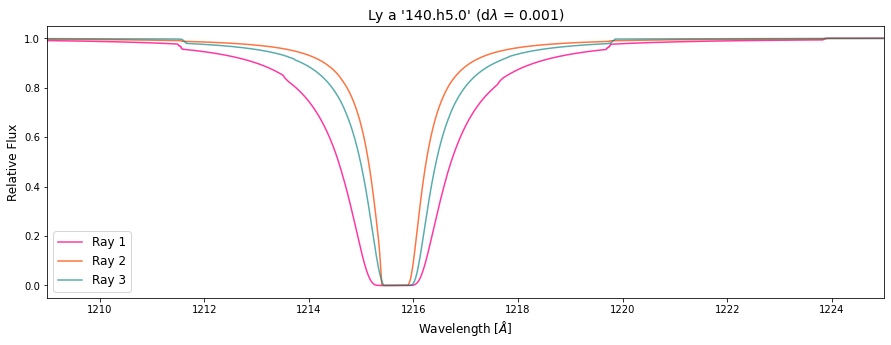

In [86]:
spec(ray_=rays, lmin=1209, lmax=1225, line='Ly a')

# Si

## Si II 1526

yt : [INFO     ] 2022-06-27 02:36:06,200 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:06,203 Creating spectrum
Adding line - Si II 1526 [1526.707000 A]: : 100%|██████████| 256/256 [00:00<00:00, 2855.83it/s]
yt : [INFO     ] 2022-06-27 02:36:06,323 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:06,366 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:06,369 Creating spectrum
Adding line - Si II 1526 [1526.707000 A]: : 100%|██████████| 256/256 [00:00<00:00, 10558.04it/s]
yt : [INFO     ] 2022-06-27 02:36:06,421 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:06,465 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:06,468 Creating spectrum
Adding line - Si II 1526 [1526.707000 A]: : 100%|██████████| 256/256 [00:00<00:00, 4843.35it/s]
yt : [INFO     ] 2022-06-27 02:36:06,550 Writing spectrum to ascii file: spec.txt.


[array([[1.525000e+03, 1.525001e+03, 1.525002e+03, ..., 1.528998e+03,
         1.528999e+03, 1.529000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.525000e+03, 1.525001e+03, 1.525002e+03, ..., 1.528998e+03,
         1.528999e+03, 1.529000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.525000e+03, 1.525001e+03, 1.525002e+03, ..., 1.528998e+03,
         1.528999e+03, 1.529000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]])]

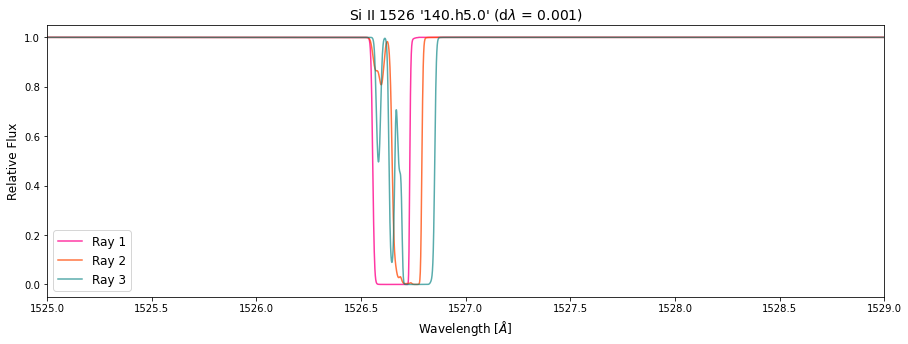

In [87]:
spec(rays, 1525, 1529, el='Si', rom_num='II', lrest=1526.7070, gamma=3.78E+08, 
     f_value=1.32E-01, DIY=True)

yt : [INFO     ] 2022-06-27 02:36:06,726 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:06,729 Creating spectrum
Adding line - Si II 1526 [1526.707000 A]: : 100%|██████████| 256/256 [00:00<00:00, 2961.83it/s]
yt : [INFO     ] 2022-06-27 02:36:06,845 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:06,867 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:06,870 Creating spectrum
Adding line - Si II 1526 [1526.707000 A]: : 100%|██████████| 256/256 [00:00<00:00, 10666.70it/s]
yt : [INFO     ] 2022-06-27 02:36:06,923 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:06,946 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:06,949 Creating spectrum
Adding line - Si II 1526 [1526.707000 A]: : 100%|██████████| 256/256 [00:00<00:00, 5010.48it/s]
yt : [INFO     ] 2022-06-27 02:36:07,030 Writing spectrum to ascii file: spec.txt.


[array([[1.526000e+03, 1.526001e+03, 1.526002e+03, ..., 1.527998e+03,
         1.527999e+03, 1.528000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.526000e+03, 1.526001e+03, 1.526002e+03, ..., 1.527998e+03,
         1.527999e+03, 1.528000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.526000e+03, 1.526001e+03, 1.526002e+03, ..., 1.527998e+03,
         1.527999e+03, 1.528000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]])]

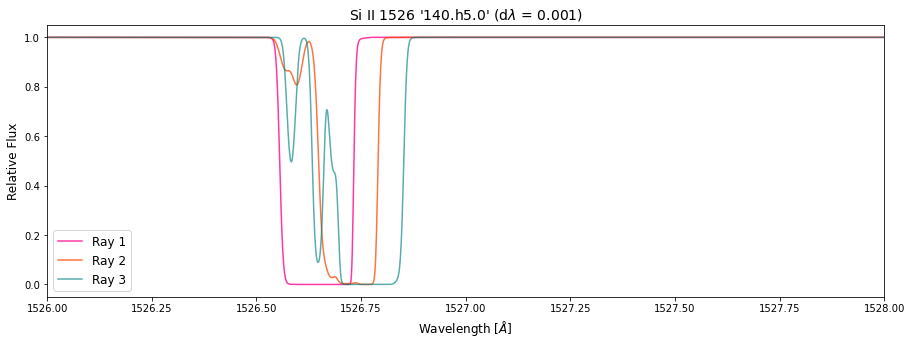

In [88]:
spec(rays, 1526, 1528, el='Si', rom_num='II', lrest=1526.7070, gamma=3.78E+08, 
     f_value=1.32E-01, DIY=True)

## Si III 1206

yt : [INFO     ] 2022-06-27 02:36:07,182 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:07,185 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]: : 100%|██████████| 256/256 [00:00<00:00, 2914.20it/s]
yt : [INFO     ] 2022-06-27 02:36:07,389 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:07,433 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:07,436 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]: : 100%|██████████| 256/256 [00:00<00:00, 9215.96it/s]
yt : [INFO     ] 2022-06-27 02:36:07,522 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:07,565 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:07,568 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]: : 100%|██████████| 256/256 [00:00<00:00, 4820.37it/s]
yt : [INFO     ] 2022-06-27 02:36:07,702 Writing spectrum to ascii file: spec.txt.


[array([[1.204500e+03, 1.204501e+03, 1.204502e+03, ..., 1.208498e+03,
         1.208499e+03, 1.208500e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.204500e+03, 1.204501e+03, 1.204502e+03, ..., 1.208498e+03,
         1.208499e+03, 1.208500e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.204500e+03, 1.204501e+03, 1.204502e+03, ..., 1.208498e+03,
         1.208499e+03, 1.208500e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]])]

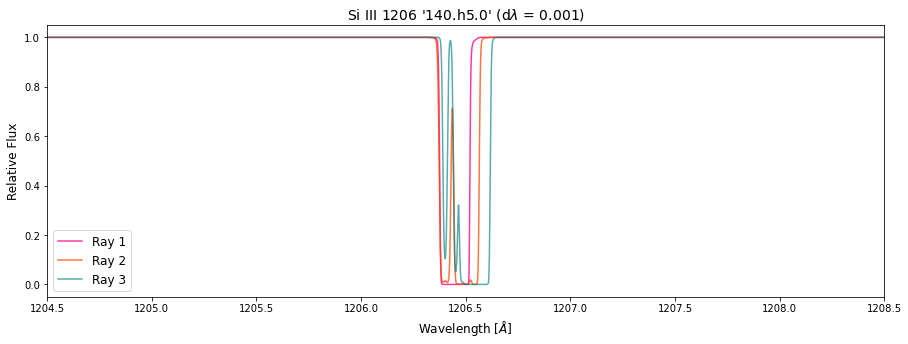

In [89]:
spec(rays, 1204.5, 1208.5, el='Si', rom_num='III', lrest=1206.5, gamma=2.57E+09, 
     f_value=1.68E+00 , DIY=True, dlam=0.001)

yt : [INFO     ] 2022-06-27 02:36:07,877 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:07,880 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]: : 100%|██████████| 256/256 [00:00<00:00, 2923.19it/s]
yt : [INFO     ] 2022-06-27 02:36:08,084 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:08,101 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:08,105 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]: : 100%|██████████| 256/256 [00:00<00:00, 9288.10it/s]
yt : [INFO     ] 2022-06-27 02:36:08,191 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:08,208 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:08,212 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]: : 100%|██████████| 256/256 [00:00<00:00, 4766.78it/s]
yt : [INFO     ] 2022-06-27 02:36:08,345 Writing spectrum to ascii file: spec.txt.


[array([[1.206000e+03, 1.206001e+03, 1.206002e+03, ..., 1.207498e+03,
         1.207499e+03, 1.207500e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.206000e+03, 1.206001e+03, 1.206002e+03, ..., 1.207498e+03,
         1.207499e+03, 1.207500e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.206000e+03, 1.206001e+03, 1.206002e+03, ..., 1.207498e+03,
         1.207499e+03, 1.207500e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]])]

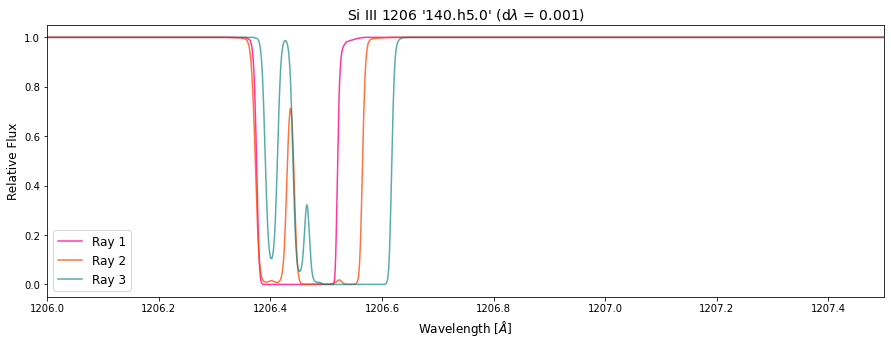

In [90]:
spec(rays, 1206, 1207.5, el='Si', rom_num='III', lrest=1206.5, gamma=2.57E+09, 
     f_value=1.68E+00 , DIY=True, dlam=0.001)

## Si IV 1393

yt : [INFO     ] 2022-06-27 02:36:08,489 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:08,492 Creating spectrum
Adding line - Si IV 1393 [1393.755000 A]: : 100%|██████████| 256/256 [00:00<00:00, 3724.93it/s]
yt : [INFO     ] 2022-06-27 02:36:08,590 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:08,633 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:08,636 Creating spectrum
Adding line - Si IV 1393 [1393.755000 A]: : 100%|██████████| 256/256 [00:00<00:00, 10917.22it/s]
yt : [INFO     ] 2022-06-27 02:36:08,688 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:08,732 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:08,735 Creating spectrum
Adding line - Si IV 1393 [1393.755000 A]: : 100%|██████████| 256/256 [00:00<00:00, 5540.75it/s]
yt : [INFO     ] 2022-06-27 02:36:08,810 Writing spectrum to ascii file: spec.txt.


[array([[1.392000e+03, 1.392001e+03, 1.392002e+03, ..., 1.395998e+03,
         1.395999e+03, 1.396000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.392000e+03, 1.392001e+03, 1.392002e+03, ..., 1.395998e+03,
         1.395999e+03, 1.396000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.392000e+03, 1.392001e+03, 1.392002e+03, ..., 1.395998e+03,
         1.395999e+03, 1.396000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]])]

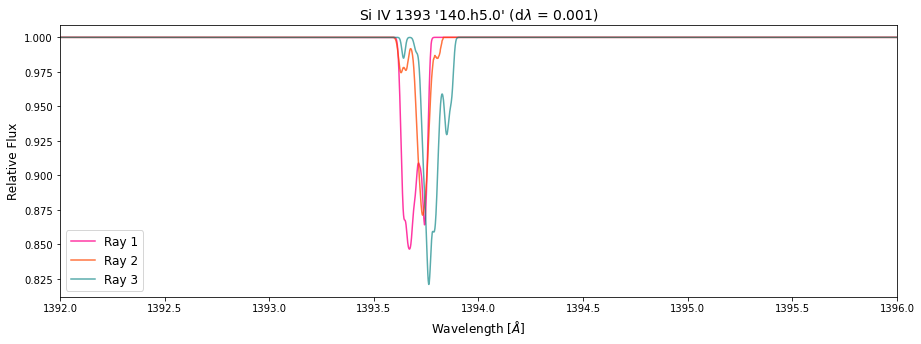

In [91]:
spec(rays, 1392, 1396, el='Si', rom_num='IV', lrest=1393.7550, gamma=9.0E+8, 
     f_value=5.24E-01, DIY=True, dlam=0.001)

# C

## C II 1334

yt : [INFO     ] 2022-06-27 02:36:08,992 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:08,995 Creating spectrum
Adding line - C II 1334 [1334.532000 A]: : 100%|██████████| 256/256 [00:00<00:00, 2835.13it/s]
yt : [INFO     ] 2022-06-27 02:36:09,114 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:09,157 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:09,160 Creating spectrum
Adding line - C II 1334 [1334.532000 A]: : 100%|██████████| 256/256 [00:00<00:00, 9786.73it/s]
yt : [INFO     ] 2022-06-27 02:36:09,214 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:09,258 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:09,261 Creating spectrum
Adding line - C II 1334 [1334.532000 A]: : 100%|██████████| 256/256 [00:00<00:00, 4478.18it/s]
yt : [INFO     ] 2022-06-27 02:36:09,346 Writing spectrum to ascii file: spec.txt.


[array([[1.333000e+03, 1.333001e+03, 1.333002e+03, ..., 1.336998e+03,
         1.336999e+03, 1.337000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.333000e+03, 1.333001e+03, 1.333002e+03, ..., 1.336998e+03,
         1.336999e+03, 1.337000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.333000e+03, 1.333001e+03, 1.333002e+03, ..., 1.336998e+03,
         1.336999e+03, 1.337000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]])]

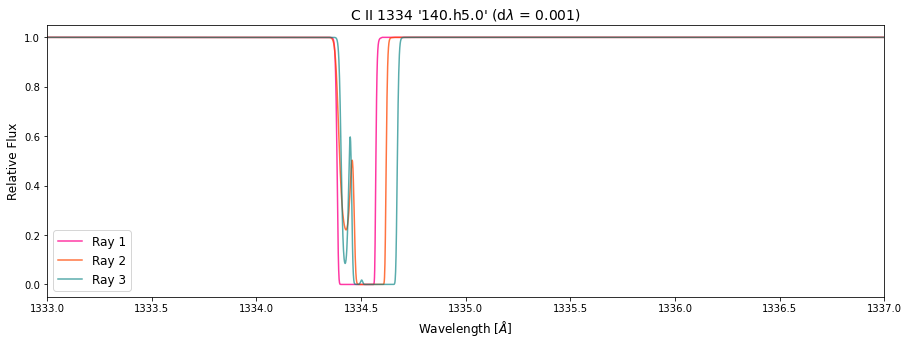

In [92]:
spec(rays, 1333, 1337, el='C', rom_num='II', lrest=1334.5320,
    gamma=2.38E+08, f_value=1.27E-01, DIY=True)

## C III 977

yt : [INFO     ] 2022-06-27 02:36:09,584 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:09,587 Creating spectrum
Adding line - C III 977 [977.020100 A]: : 100%|██████████| 256/256 [00:00<00:00, 2784.67it/s]
yt : [INFO     ] 2022-06-27 02:36:09,801 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:09,844 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:09,847 Creating spectrum
Adding line - C III 977 [977.020100 A]: : 100%|██████████| 256/256 [00:00<00:00, 8622.42it/s]
yt : [INFO     ] 2022-06-27 02:36:09,937 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:09,981 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:09,984 Creating spectrum
Adding line - C III 977 [977.020100 A]: : 100%|██████████| 256/256 [00:00<00:00, 4439.59it/s]
yt : [INFO     ] 2022-06-27 02:36:10,128 Writing spectrum to ascii file: spec.txt.


[array([[975.   , 975.001, 975.002, ..., 978.998, 978.999, 979.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]]),
 array([[975.   , 975.001, 975.002, ..., 978.998, 978.999, 979.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]]),
 array([[975.   , 975.001, 975.002, ..., 978.998, 978.999, 979.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]])]

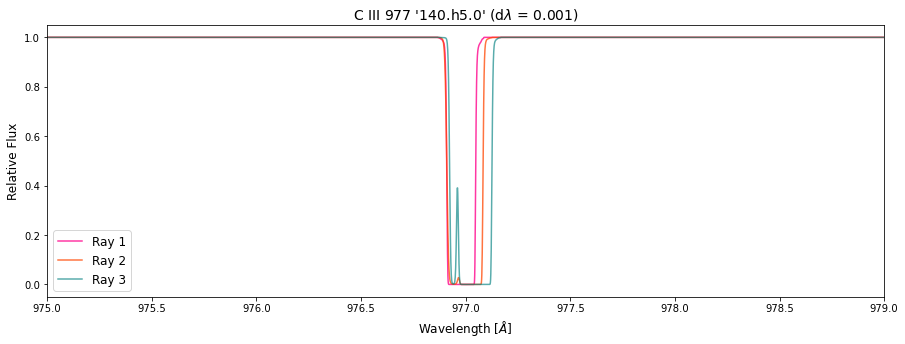

In [93]:
spec(rays, 975, 979, el='C', rom_num='III', lrest=977.0201,
    gamma=1.79E+09, f_value=7.67E-01, DIY=True, dlam=0.001)

yt : [INFO     ] 2022-06-27 02:36:10,301 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:10,304 Creating spectrum
Adding line - C III 977 [977.020100 A]: : 100%|██████████| 256/256 [00:00<00:00, 2769.69it/s]
yt : [INFO     ] 2022-06-27 02:36:10,520 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:10,544 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:10,547 Creating spectrum
Adding line - C III 977 [977.020100 A]: : 100%|██████████| 256/256 [00:00<00:00, 8326.87it/s]
yt : [INFO     ] 2022-06-27 02:36:10,640 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:10,664 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:10,668 Creating spectrum
Adding line - C III 977 [977.020100 A]: : 100%|██████████| 256/256 [00:00<00:00, 4394.55it/s]
yt : [INFO     ] 2022-06-27 02:36:10,819 Writing spectrum to ascii file: spec.txt.


[array([[976.   , 976.001, 976.002, ..., 977.998, 977.999, 978.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]]),
 array([[976.   , 976.001, 976.002, ..., 977.998, 977.999, 978.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]]),
 array([[976.   , 976.001, 976.002, ..., 977.998, 977.999, 978.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]])]

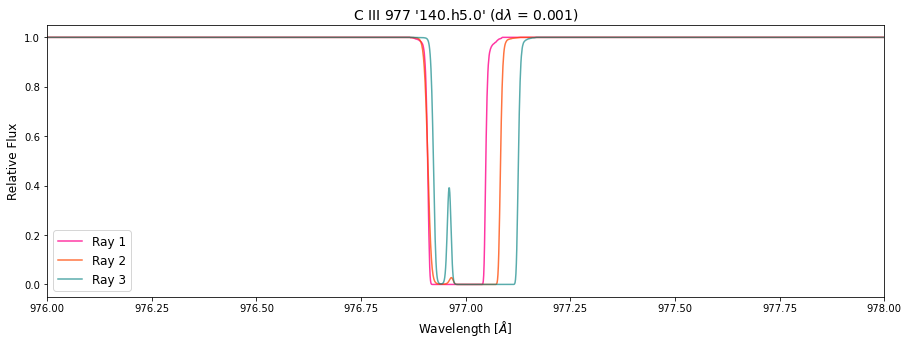

In [94]:
spec(rays, 976, 978, el='C', rom_num='III', lrest=977.0201,
    gamma=1.79E+09, f_value=7.67E-01, DIY=True, dlam=0.001)

## C IV 1548

yt : [INFO     ] 2022-06-27 02:36:10,970 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:10,974 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 256/256 [00:00<00:00, 5650.62it/s]
yt : [INFO     ] 2022-06-27 02:36:11,050 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:11,084 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:11,087 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 256/256 [00:00<00:00, 5398.35it/s]
yt : [INFO     ] 2022-06-27 02:36:11,165 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:11,199 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:11,202 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 256/256 [00:00<00:00, 5582.35it/s]
yt : [INFO     ] 2022-06-27 02:36:11,278 Writing spectrum to ascii file: spec.txt.


[array([[1.547000e+03, 1.547001e+03, 1.547002e+03, ..., 1.549998e+03,
         1.549999e+03, 1.550000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.547000e+03, 1.547001e+03, 1.547002e+03, ..., 1.549998e+03,
         1.549999e+03, 1.550000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.547000e+03, 1.547001e+03, 1.547002e+03, ..., 1.549998e+03,
         1.549999e+03, 1.550000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]])]

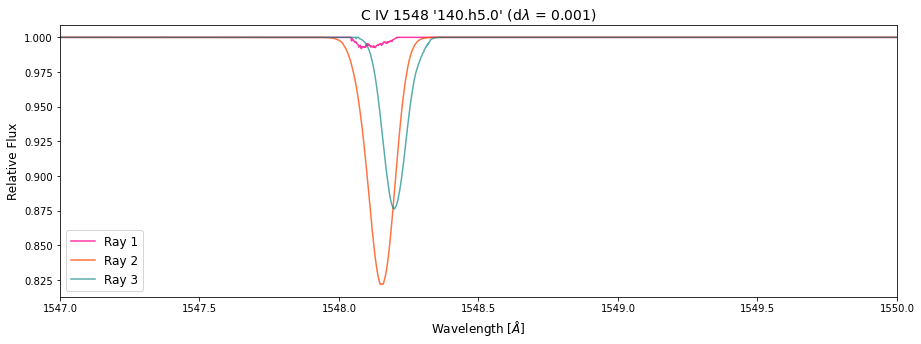

In [95]:
spec(rays, 1547,1550, line='C IV 1548', dlam=0.001)

# O

## O I 1302

yt : [INFO     ] 2022-06-27 02:36:11,449 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:11,452 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 256/256 [00:00<00:00, 2814.80it/s]
yt : [INFO     ] 2022-06-27 02:36:11,574 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:11,619 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:11,622 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 256/256 [00:00<00:00, 10904.36it/s]
yt : [INFO     ] 2022-06-27 02:36:11,675 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:11,719 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:11,722 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 256/256 [00:00<00:00, 4940.56it/s]
yt : [INFO     ] 2022-06-27 02:36:11,804 Writing spectrum to ascii file: spec.txt.


[array([[1.300000e+03, 1.300001e+03, 1.300002e+03, ..., 1.303998e+03,
         1.303999e+03, 1.304000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.300000e+03, 1.300001e+03, 1.300002e+03, ..., 1.303998e+03,
         1.303999e+03, 1.304000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.300000e+03, 1.300001e+03, 1.300002e+03, ..., 1.303998e+03,
         1.303999e+03, 1.304000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]])]

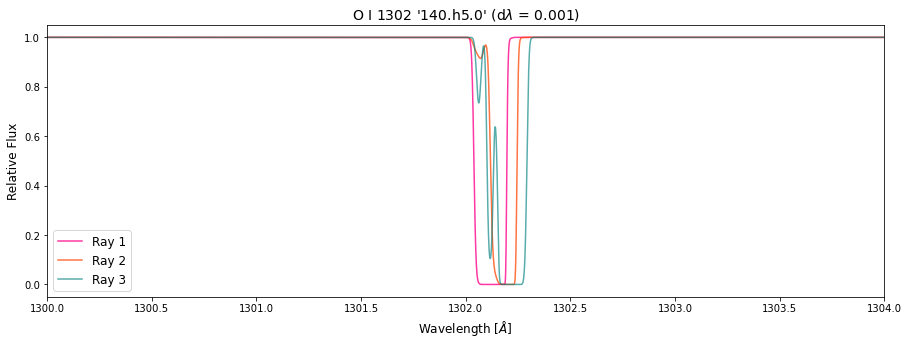

In [96]:
spec(rays, 1300, 1304, line='O I 1302')

yt : [INFO     ] 2022-06-27 02:39:10,506 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:39:10,519 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 256/256 [00:00<00:00, 2759.13it/s]
yt : [INFO     ] 2022-06-27 02:39:10,655 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:39:10,678 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:39:10,681 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 256/256 [00:00<00:00, 10385.35it/s]
yt : [INFO     ] 2022-06-27 02:39:10,739 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:39:10,763 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:39:10,766 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 256/256 [00:00<00:00, 4877.87it/s]
yt : [INFO     ] 2022-06-27 02:39:10,850 Writing spectrum to ascii file: spec.txt.


[array([[1.301000e+03, 1.301001e+03, 1.301002e+03, ..., 1.302998e+03,
         1.302999e+03, 1.303000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.301000e+03, 1.301001e+03, 1.301002e+03, ..., 1.302998e+03,
         1.302999e+03, 1.303000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.301000e+03, 1.301001e+03, 1.301002e+03, ..., 1.302998e+03,
         1.302999e+03, 1.303000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]])]

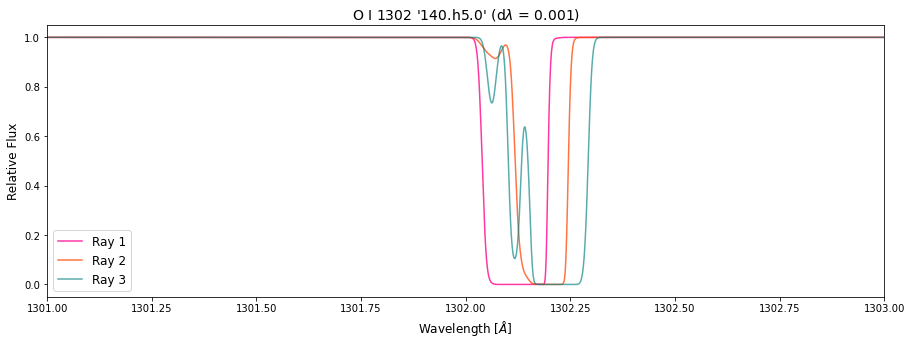

In [121]:
spec(rays, 1301, 1303, line='O I 1302')

## O II 833 and 834

yt : [INFO     ] 2022-06-27 02:41:43,482 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:41:43,496 Creating spectrum
Adding line - O II 833 [833.801900 A]: : 100%|██████████| 256/256 [00:00<00:00, 2639.31it/s]
yt : [INFO     ] 2022-06-27 02:41:43,807 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:41:43,877 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:41:43,880 Creating spectrum
Adding line - O II 833 [833.801900 A]: : 100%|██████████| 256/256 [00:00<00:00, 8424.68it/s]
yt : [INFO     ] 2022-06-27 02:41:43,994 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:41:44,038 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:41:44,041 Creating spectrum
Adding line - O II 833 [833.801900 A]: : 100%|██████████| 256/256 [00:00<00:00, 4065.69it/s]
yt : [INFO     ] 2022-06-27 02:41:44,239 Writing spectrum to ascii file: spec.txt.


[array([[831.5  , 831.501, 831.502, ..., 835.498, 835.499, 835.5  ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]]),
 array([[831.5  , 831.501, 831.502, ..., 835.498, 835.499, 835.5  ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]]),
 array([[831.5  , 831.501, 831.502, ..., 835.498, 835.499, 835.5  ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]])]

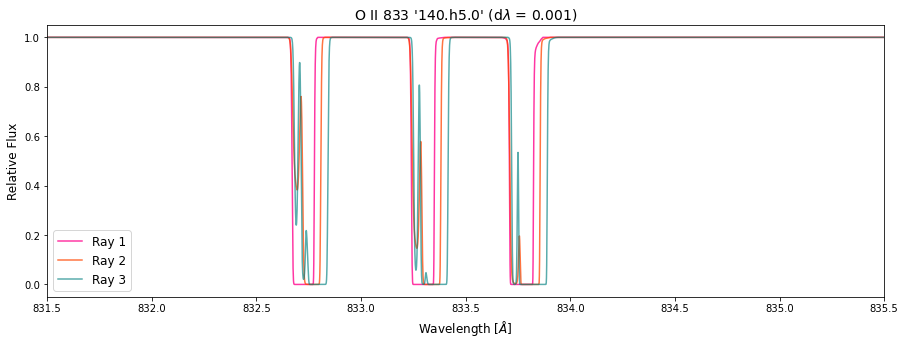

In [122]:
spec(rays, 831.5, 835.5, el='O', rom_num='II', lrest=833.8019,
    gamma=8.51E+08, f_value=2.66E-01, DIY=True)

yt : [INFO     ] 2022-06-27 02:43:45,610 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:43:45,626 Creating spectrum
Adding line - O II 833 [833.801900 A]: : 100%|██████████| 256/256 [00:00<00:00, 2628.76it/s]
yt : [INFO     ] 2022-06-27 02:43:45,933 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:43:45,951 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:43:45,955 Creating spectrum
Adding line - O II 833 [833.801900 A]: : 100%|██████████| 256/256 [00:00<00:00, 8384.94it/s]
yt : [INFO     ] 2022-06-27 02:43:46,070 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:43:46,089 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:43:46,093 Creating spectrum
Adding line - O II 833 [833.801900 A]: : 100%|██████████| 256/256 [00:00<00:00, 4078.45it/s]
yt : [INFO     ] 2022-06-27 02:43:46,290 Writing spectrum to ascii file: spec.txt.


[array([[832.5  , 832.501, 832.502, ..., 833.998, 833.999, 834.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]]),
 array([[832.5  , 832.501, 832.502, ..., 833.998, 833.999, 834.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]]),
 array([[832.5  , 832.501, 832.502, ..., 833.998, 833.999, 834.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]])]

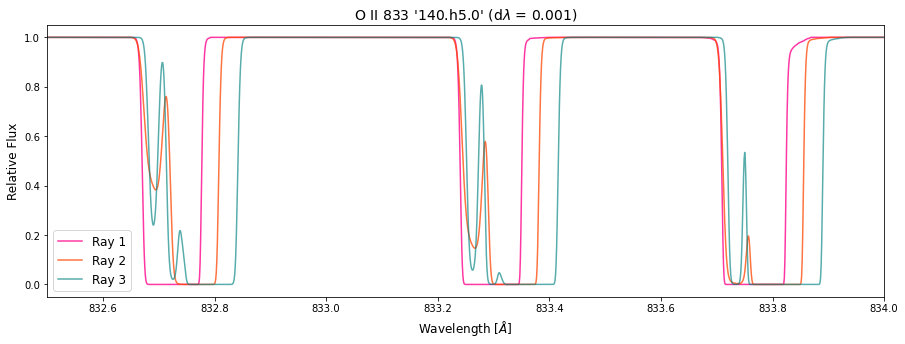

In [123]:
spec(rays, 832.5, 834, el='O', rom_num='II', lrest=833.8019,
    gamma=8.51E+08, f_value=2.66E-01, DIY=True)

yt : [INFO     ] 2022-06-27 02:36:12,456 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:12,460 Creating spectrum
Adding line - O II 834 [834.465400 A]: : 100%|██████████| 256/256 [00:00<00:00, 2935.44it/s]
yt : [INFO     ] 2022-06-27 02:36:12,669 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:12,713 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:12,716 Creating spectrum
Adding line - O II 834 [834.465400 A]: : 100%|██████████| 256/256 [00:00<00:00, 8875.00it/s]
yt : [INFO     ] 2022-06-27 02:36:12,804 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:12,848 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:12,852 Creating spectrum
Adding line - O II 834 [834.465400 A]: : 100%|██████████| 256/256 [00:00<00:00, 4668.54it/s]
yt : [INFO     ] 2022-06-27 02:36:12,993 Writing spectrum to ascii file: spec.txt.


[array([[833.   , 833.001, 833.002, ..., 836.998, 836.999, 837.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]]),
 array([[833.   , 833.001, 833.002, ..., 836.998, 836.999, 837.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]]),
 array([[833.   , 833.001, 833.002, ..., 836.998, 836.999, 837.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]])]

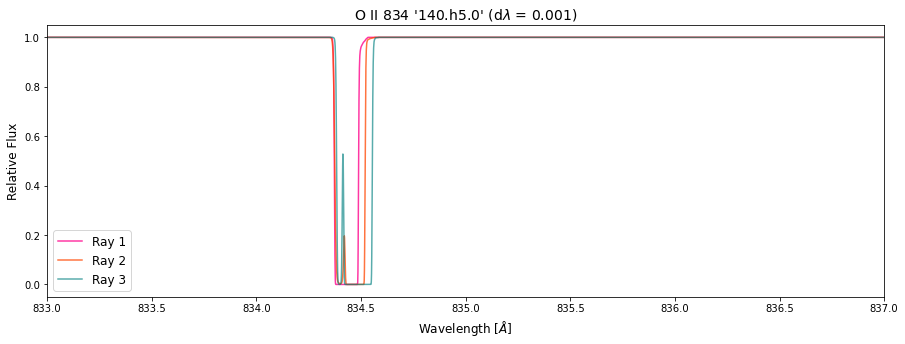

In [98]:
spec(rays, 833, 837, el='O', rom_num='II', lrest=834.4654,
    gamma=8.43E+08, f_value=1.32E-01, DIY=True)

yt : [INFO     ] 2022-06-27 02:36:13,176 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:13,180 Creating spectrum
Adding line - O II 834 [834.465400 A]: : 100%|██████████| 256/256 [00:00<00:00, 2771.31it/s]
yt : [INFO     ] 2022-06-27 02:36:13,393 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:13,406 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:13,410 Creating spectrum
Adding line - O II 834 [834.465400 A]: : 100%|██████████| 256/256 [00:00<00:00, 9207.34it/s]
yt : [INFO     ] 2022-06-27 02:36:13,499 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:13,512 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:13,516 Creating spectrum
Adding line - O II 834 [834.465400 A]: : 100%|██████████| 256/256 [00:00<00:00, 4776.58it/s]
yt : [INFO     ] 2022-06-27 02:36:13,652 Writing spectrum to ascii file: spec.txt.


[array([[834.1  , 834.101, 834.102, ..., 835.098, 835.099, 835.1  ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]]),
 array([[834.1  , 834.101, 834.102, ..., 835.098, 835.099, 835.1  ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]]),
 array([[834.1  , 834.101, 834.102, ..., 835.098, 835.099, 835.1  ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]])]

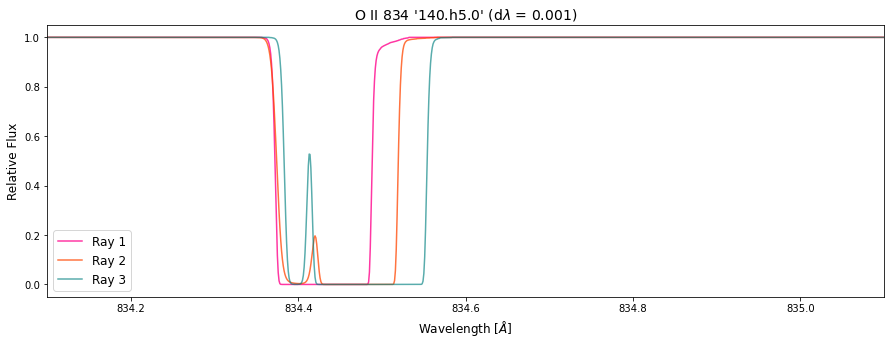

In [99]:
spec(rays, 834.1, 835.1, el='O', rom_num='II', lrest=834.4654,
    gamma=8.43E+08, f_value=1.32E-01, DIY=True)

## O III 702

yt : [INFO     ] 2022-06-27 02:36:13,790 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:13,794 Creating spectrum
Adding line - O III 702 [702.337000 A]: : 100%|██████████| 256/256 [00:00<00:00, 3936.05it/s]
yt : [INFO     ] 2022-06-27 02:36:13,957 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:14,000 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:14,003 Creating spectrum
Adding line - O III 702 [702.337000 A]: : 100%|██████████| 256/256 [00:00<00:00, 11024.95it/s]
yt : [INFO     ] 2022-06-27 02:36:14,081 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:14,125 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:14,129 Creating spectrum
Adding line - O III 702 [702.337000 A]: : 100%|██████████| 256/256 [00:00<00:00, 6158.12it/s]
yt : [INFO     ] 2022-06-27 02:36:14,243 Writing spectrum to ascii file: spec.txt.


[array([[700.   , 700.001, 700.002, ..., 703.998, 703.999, 704.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]]),
 array([[700.   , 700.001, 700.002, ..., 703.998, 703.999, 704.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]]),
 array([[700.   , 700.001, 700.002, ..., 703.998, 703.999, 704.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]])]

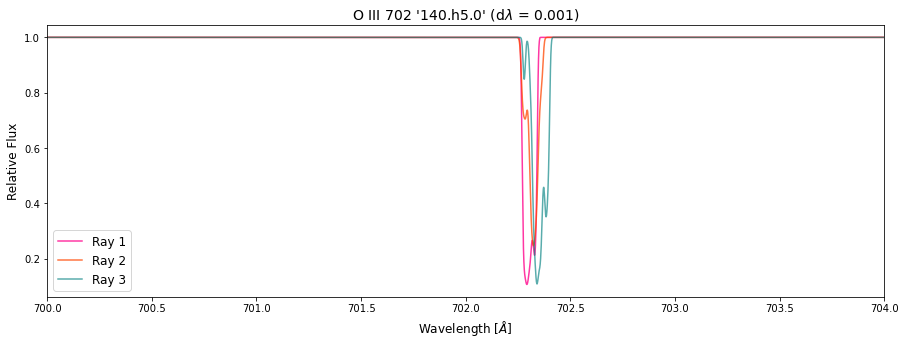

In [100]:
spec(rays, 700, 704, el='O', rom_num='III', lrest=702.3370,
    gamma=6.17E+08, f_value=1.37E-01, DIY=True)

yt : [INFO     ] 2022-06-27 02:36:14,420 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:14,424 Creating spectrum
Adding line - O III 702 [702.337000 A]: : 100%|██████████| 256/256 [00:00<00:00, 3550.72it/s]
yt : [INFO     ] 2022-06-27 02:36:14,597 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:14,613 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:14,616 Creating spectrum
Adding line - O III 702 [702.337000 A]: : 100%|██████████| 256/256 [00:00<00:00, 10962.14it/s]
yt : [INFO     ] 2022-06-27 02:36:14,700 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:14,715 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:14,718 Creating spectrum
Adding line - O III 702 [702.337000 A]: : 100%|██████████| 256/256 [00:00<00:00, 6141.28it/s]
yt : [INFO     ] 2022-06-27 02:36:14,831 Writing spectrum to ascii file: spec.txt.


[array([[701.75 , 701.751, 701.752, ..., 702.998, 702.999, 703.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]]),
 array([[701.75 , 701.751, 701.752, ..., 702.998, 702.999, 703.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]]),
 array([[701.75 , 701.751, 701.752, ..., 702.998, 702.999, 703.   ],
        [  1.   ,   1.   ,   1.   , ...,   1.   ,   1.   ,   1.   ]])]

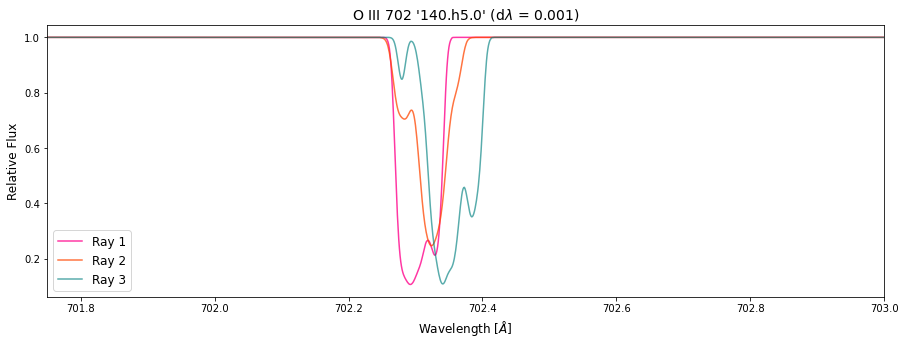

In [101]:
spec(rays, 701.75, 703, el='O', rom_num='III', lrest=702.3370,
    gamma=6.17E+08, f_value=1.37E-01, DIY=True)

# Al

## Al II 1670

yt : [INFO     ] 2022-06-27 02:36:15,859 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:15,862 Creating spectrum
Adding line - Al II 1671 [1670.787400 A]: : 100%|██████████| 256/256 [00:00<00:00, 2669.09it/s]
yt : [INFO     ] 2022-06-27 02:36:15,988 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:16,033 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:16,036 Creating spectrum
Adding line - Al II 1671 [1670.787400 A]: : 100%|██████████| 256/256 [00:00<00:00, 9261.90it/s]
yt : [INFO     ] 2022-06-27 02:36:16,094 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:16,139 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:16,142 Creating spectrum
Adding line - Al II 1671 [1670.787400 A]: : 100%|██████████| 256/256 [00:00<00:00, 4676.15it/s]
yt : [INFO     ] 2022-06-27 02:36:16,228 Writing spectrum to ascii file: spec.txt.


[array([[1.669000e+03, 1.669001e+03, 1.669002e+03, ..., 1.672998e+03,
         1.672999e+03, 1.673000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.669000e+03, 1.669001e+03, 1.669002e+03, ..., 1.672998e+03,
         1.672999e+03, 1.673000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.669000e+03, 1.669001e+03, 1.669002e+03, ..., 1.672998e+03,
         1.672999e+03, 1.673000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]])]

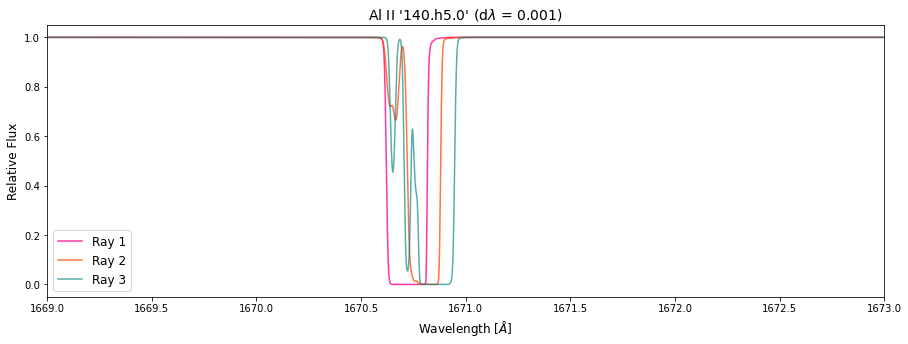

In [104]:
spec(rays, 1669, 1673, line='Al II')

## Al III 1854

yt : [INFO     ] 2022-06-27 02:36:16,409 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:16,412 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 256/256 [00:00<00:00, 3398.20it/s]
yt : [INFO     ] 2022-06-27 02:36:16,522 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:16,567 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:16,571 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 256/256 [00:00<00:00, 11888.85it/s]
yt : [INFO     ] 2022-06-27 02:36:16,625 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:16,669 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:16,672 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 256/256 [00:00<00:00, 6011.82it/s]
yt : [INFO     ] 2022-06-27 02:36:16,744 Writing spectrum to ascii file: spec.txt.


[array([[1.853500e+03, 1.853501e+03, 1.853502e+03, ..., 1.857498e+03,
         1.857499e+03, 1.857500e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.853500e+03, 1.853501e+03, 1.853502e+03, ..., 1.857498e+03,
         1.857499e+03, 1.857500e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.853500e+03, 1.853501e+03, 1.853502e+03, ..., 1.857498e+03,
         1.857499e+03, 1.857500e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]])]

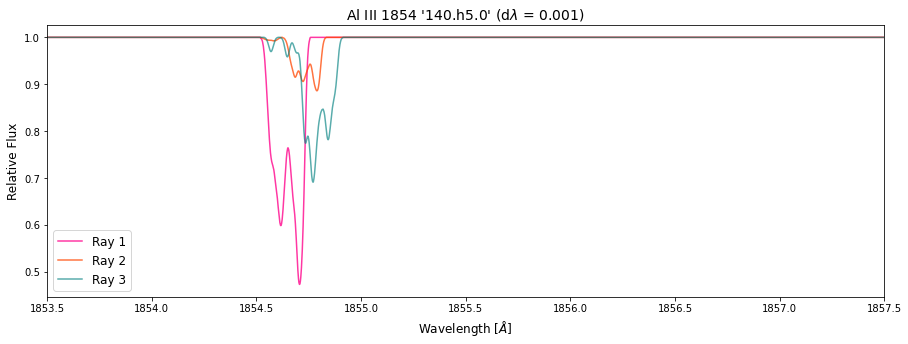

In [105]:
spec(rays, 1853.5,1857.5,el='Al',rom_num='III',lrest=1854.72, 
     gamma=5.57E+08, f_value=5.75E-01, DIY=True, dlam=0.001)

# Fe

## Fe II 2600

yt : [INFO     ] 2022-06-27 02:37:14,177 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:37:14,190 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 256/256 [00:00<00:00, 2592.43it/s]
yt : [INFO     ] 2022-06-27 02:37:14,342 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:37:14,386 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:37:14,390 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 256/256 [00:00<00:00, 10098.20it/s]
yt : [INFO     ] 2022-06-27 02:37:14,445 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:37:14,489 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:37:14,492 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 256/256 [00:00<00:00, 4811.30it/s]
yt : [INFO     ] 2022-06-27 02:37:14,575 Writing spectrum to ascii file: spec.txt.


[array([[2.598000e+03, 2.598001e+03, 2.598002e+03, ..., 2.601998e+03,
         2.601999e+03, 2.602000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[2.598000e+03, 2.598001e+03, 2.598002e+03, ..., 2.601998e+03,
         2.601999e+03, 2.602000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[2.598000e+03, 2.598001e+03, 2.598002e+03, ..., 2.601998e+03,
         2.601999e+03, 2.602000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]])]

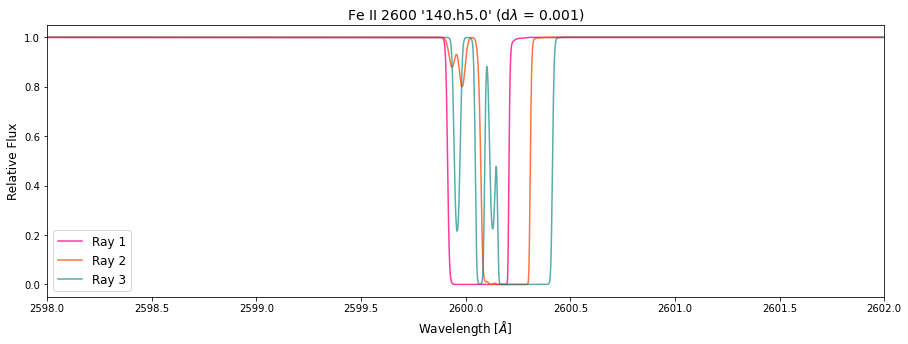

In [119]:
spec(rays, 2598,2602,
    el='Fe', rom_num='II', lrest=2600.17, gamma=2.37E+08, f_value=2.4E-01, DIY=True)

## Fe III 1122

yt : [INFO     ] 2022-06-27 02:37:44,279 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:37:44,292 Creating spectrum
Adding line - Fe III 1122 [1122.524100 A]: : 100%|██████████| 256/256 [00:00<00:00, 3582.48it/s]
yt : [INFO     ] 2022-06-27 02:37:44,406 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:37:44,450 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:37:44,453 Creating spectrum
Adding line - Fe III 1122 [1122.524100 A]: : 100%|██████████| 256/256 [00:00<00:00, 11414.29it/s]
yt : [INFO     ] 2022-06-27 02:37:44,505 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:37:44,549 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:37:44,552 Creating spectrum
Adding line - Fe III 1122 [1122.524100 A]: : 100%|██████████| 256/256 [00:00<00:00, 6027.08it/s]
yt : [INFO     ] 2022-06-27 02:37:44,624 Writing spectrum to ascii file: spec.txt.


[array([[1.120500e+03, 1.120501e+03, 1.120502e+03, ..., 1.124498e+03,
         1.124499e+03, 1.124500e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.120500e+03, 1.120501e+03, 1.120502e+03, ..., 1.124498e+03,
         1.124499e+03, 1.124500e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.120500e+03, 1.120501e+03, 1.120502e+03, ..., 1.124498e+03,
         1.124499e+03, 1.124500e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]])]

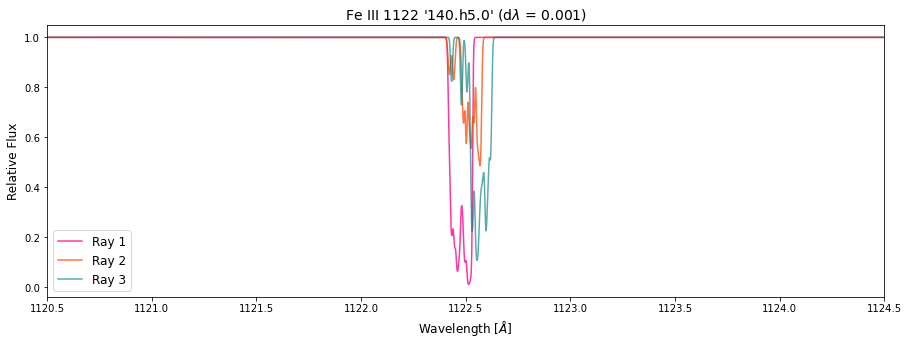

In [120]:
spec(rays, 1120.5,1124.5,
    el='Fe', rom_num='III', lrest=1122.5241, gamma=5.42E+08, f_value=7.97E-02, DIY=True)

yt : [INFO     ] 2022-06-27 02:36:19,173 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:19,177 Creating spectrum
Adding line - Fe III 1122 [1122.524100 A]: : 100%|██████████| 256/256 [00:00<00:00, 3652.75it/s]
yt : [INFO     ] 2022-06-27 02:36:19,279 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:19,298 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:19,301 Creating spectrum
Adding line - Fe III 1122 [1122.524100 A]: : 100%|██████████| 256/256 [00:00<00:00, 10797.67it/s]
yt : [INFO     ] 2022-06-27 02:36:19,357 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:19,378 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:19,381 Creating spectrum
Adding line - Fe III 1122 [1122.524100 A]: : 100%|██████████| 256/256 [00:00<00:00, 5996.41it/s]
yt : [INFO     ] 2022-06-27 02:36:19,453 Writing spectrum to ascii file: spec.txt.


[array([[1.122000e+03, 1.122001e+03, 1.122002e+03, ..., 1.123498e+03,
         1.123499e+03, 1.123500e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.122000e+03, 1.122001e+03, 1.122002e+03, ..., 1.123498e+03,
         1.123499e+03, 1.123500e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[1.122000e+03, 1.122001e+03, 1.122002e+03, ..., 1.123498e+03,
         1.123499e+03, 1.123500e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]])]

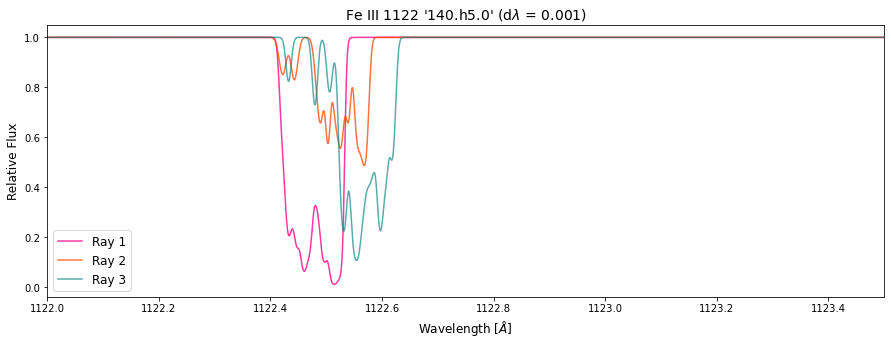

In [111]:
spec(rays, 1122,1123.5,
    el='Fe', rom_num='III', lrest=1122.5241, gamma=5.42E+08, f_value=7.97E-02, DIY=True)

# Mg

## Mg II 2796

yt : [INFO     ] 2022-06-27 02:36:20,405 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:20,409 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 256/256 [00:00<00:00, 1844.11it/s]
yt : [INFO     ] 2022-06-27 02:36:20,580 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:20,624 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:20,626 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 256/256 [00:00<00:00, 7575.54it/s]
yt : [INFO     ] 2022-06-27 02:36:20,689 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-06-27 02:36:20,733 Setting instrument to Custom
yt : [INFO     ] 2022-06-27 02:36:20,736 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 256/256 [00:00<00:00, 3318.90it/s]
yt : [INFO     ] 2022-06-27 02:36:20,845 Writing spectrum to ascii file: spec.txt.


[array([[2.795000e+03, 2.795001e+03, 2.795002e+03, ..., 2.798998e+03,
         2.798999e+03, 2.799000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[2.795000e+03, 2.795001e+03, 2.795002e+03, ..., 2.798998e+03,
         2.798999e+03, 2.799000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]]),
 array([[2.795000e+03, 2.795001e+03, 2.795002e+03, ..., 2.798998e+03,
         2.798999e+03, 2.799000e+03],
        [1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
         1.000000e+00, 1.000000e+00]])]

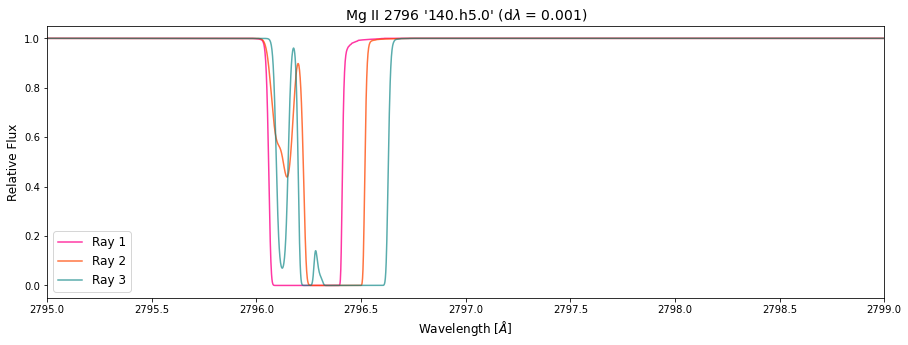

In [114]:
spec(rays, 2795,2799, 
     el='Mg', rom_num='II', lrest=2796.35, gamma=2.68E+08, f_value=6.29E-01, DIY=True)